In [2]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
from core.evaluation import MLEvaluator
from core.reconstruction import KerasFFRecoBase
import core
import keras


PLOTS_DIR = "plots/plot_HLF_comp_histories/"
CONFIG_PATH = "../config/workspace_config.yaml"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)


load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)


data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], max_events=2_000_000, event_numbers="odd"
)
X_val, y_val = DataProcessor.get_data()

In [4]:
MODEL_DIRS = ["../models/model_d128_l6_h8_6M_events/", "../models/model_d256_l6_h8_full_sample/"]
MODEL_CONFIGS = [data_config, data_config]
MODEL_NAMES = ["Model 1", "Model 2"]
MODEL_X_TEST = [X_val, X_val]
MODEL_Y_TEST = [y_val, y_val]

ml_reconstructors = []
ml_evaluators = []
for i in range(len(MODEL_DIRS)):
    reconstructor = KerasFFRecoBase(MODEL_CONFIGS[i], name=MODEL_NAMES[i], perform_regression=False)
    reconstructor.load_model(MODEL_DIRS[i] + "odd_model.keras")
    ml_reconstructors.append(reconstructor)

evaluator = MLEvaluator(
    reconstructor=ml_reconstructors,
    X_test=MODEL_X_TEST,
    y_test=MODEL_Y_TEST,
)
plt.rcParams.update({"font.size": 14})


I0000 00:00:1768493206.031136 1538260 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 223 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0
I0000 00:00:1768493206.052935 1538260 cuda_executor.cc:479] failed to allocate 223.12MiB (233963520 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


Model loaded from ../models/model_d128_l6_h8_6M_events/odd_model.keras
Training history loaded from ../models/model_d128_l6_h8_6M_events/odd_model_history.npz
Model loaded from ../models/model_d256_l6_h8_full_sample/odd_model.keras
Training history loaded from ../models/model_d256_l6_h8_full_sample/odd_model_history.npz


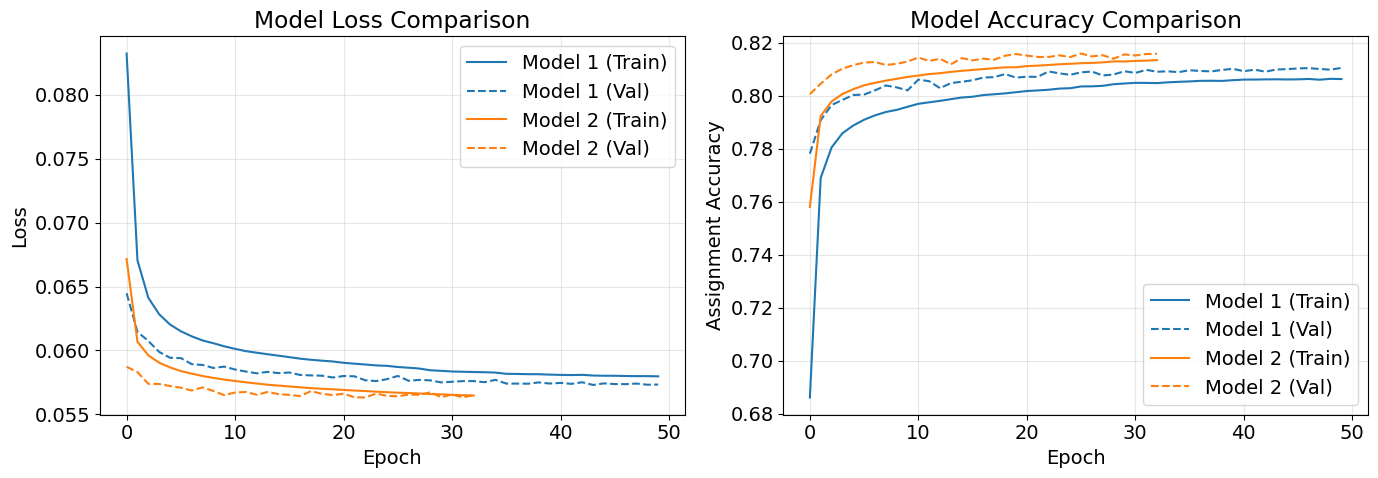

In [5]:
fig, ax = evaluator.plot_training_history()
fig.savefig(PLOTS_DIR + "training_histories_comparison.pdf")


In [ ]:
evaluator.save_accuracy_latex_table(
    confidence=0.95,
    n_bootstrap=10,
    save_dir=PLOTS_DIR)

In [ ]:
def rename_features(str):
    if str == "jet_b_tag":
        return "$b$-tag"
    elif str == "jet_pt":
        return r"$p_{T}(\text{jet})$"
    elif str == "jet_eta":
        return r"$\eta(\text{jet})$"
    elif str == "jet_phi":
        return r"$\phi(\text{jet})$"
    elif str == "jet_e":
        return r"$E(\text{jet})$"
    elif str == "lep_pt":
        return r"$p_{T}(\ell)$"
    elif str == "lep_eta":
        return r"$\eta(\ell)$"
    elif str == "lep_phi":
        return r"$\phi(\ell)$"
    elif str == "lep_e":
        return r"$E(\ell)$"
    elif str == "met_met":
        return r"$p_{T}(miss)$"
    elif str == "met_phi":
        return r"$\phi(miss)$"
    elif str == "m_l1j":
        return r"$m(\ell^+, \text{jet})$"
    elif str == "m_l2j":
        return r"$m(\ell^-, \text{jet})$"
    elif str == "dR_l1j":
        return r"$\Delta R(\ell^+, \text{jet})$"
    elif str == "dR_l2j":
        return r"$\Delta R(\ell^-, \text{jet})$"
    else:
        return str

evaluator.plot_feature_importance(save_dir=PLOTS_DIR, num_repeats=1, rename_features=rename_features)